# CPSC 330 Lecture 3

### Lecture outline

- Train/Test error and overfitting (15 mins)
- Overfitting and the "fundamental trade-off" (15 mins)
- Break (5 mins)
- Splitting your data and cross-validation (15 mins)
- Video/lecture review (25 mins)

# NOTE

reconcile with assumed video pre-watching from 340

# NOTE

see material from SIMUW lecture

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
import graphviz

In [3]:
from plot_classifier import plot_classifier

In [4]:
pd.set_option('display.max_rows', 9)
plt.rcParams['font.size'] = 16

## Train/Test error (15 mins)

Let's do a quick review of last class:

In [5]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
df["lon"] *= -1
X = df.drop(columns=['vote'])
y = df[['vote']]

In [6]:
blue = df.query('vote == "blue"')
red  = df.query('vote == "red"')

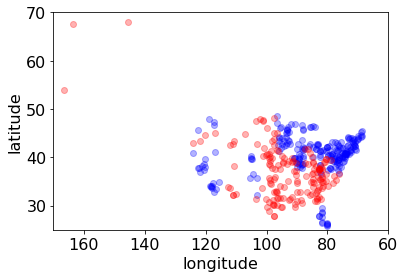

In [7]:
def show_cities(df):
    plt.scatter(df.query('vote == "blue"')["lon"], df.query('vote == "blue"')["lat"], color="blue", alpha=0.3);
    plt.scatter(df.query('vote == "red"')["lon"], df.query('vote == "red"')["lat"], color="red", alpha=0.3);
    plt.ylabel("latitude");
    plt.xlabel("longitude");
    plt.xlim(60,170)
    plt.ylim(25,70)
    plt.gca().invert_xaxis();
show_cities(df)

### Decision stump (depth=1)

In [8]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

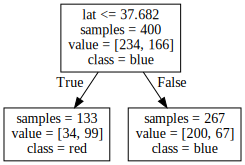

In [9]:
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=["blue", "red"],
                                impurity=False))

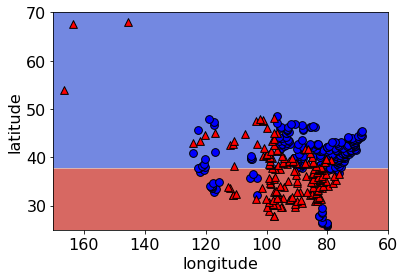

In [10]:
def plot_classifier_cities(X, y, model):
    plt.figure()
    ax = plt.gca()
    plot_classifier(X, y, model, ax=ax, ticks=True, lims=(60,170,25,70));
    plt.ylabel("latitude");
    plt.xlabel("longitude");
    ax.invert_xaxis();
plot_classifier_cities(X, y, model)

In [11]:
print(f"Error rate: {1 - model.score(X, y):.2f}")

Error rate: 0.25


### Decision tree (depth=20)

In [12]:
model = DecisionTreeClassifier(max_depth=20).fit(X, y)

In [13]:
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=["red", "blue"],
                                impurity=False)); # remove semicolon to display image

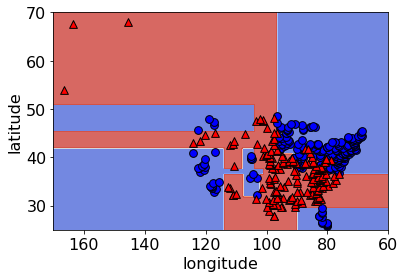

In [14]:
plot_classifier_cities(X, y, model)

In [15]:
print(f"Error rate: {1 - model.score(X, y):.2f}")

Error rate: 0.00


### How does error rate change vs. max_depth?

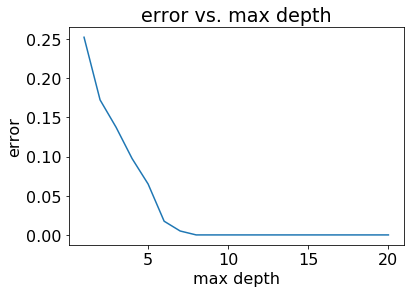

In [16]:
# calculation loop
max_depth = []
error = []
for depth in np.arange(1, 21):
    model = DecisionTreeClassifier(max_depth = depth).fit(X, y)  
    max_depth.append(depth)    
    error.append(1 - model.score(X, y))

plt.plot(max_depth, error);
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");

- Why not just use a very deep decision tree for every supervised learning problem and get super high accuracy?
- Well, the goal of supervised learning is to predict unseen/new data...
  - The above decision tree has an error of 0 on the training data.
  - It perfectly labels the data we used to make the tree.
  - But we want to know how our model performs on data not used in training.
  - We will split our original dataset into 2 parts
  - We will split our original dataset into 2 parts, 1 for "training" and 1 for "validation"

In [17]:
X.shape

(400, 2)

In [18]:
# Use the firs t half as training data
df_train = df.iloc[:200]

# Use the second half as testing data
df_valid = df.iloc[200:]

In [19]:
X_train = df_train.drop(columns=['vote'])
y_train = df_train[['vote']]

X_valid = df_valid.drop(columns=['vote'])
y_valid = df_valid[['vote']]

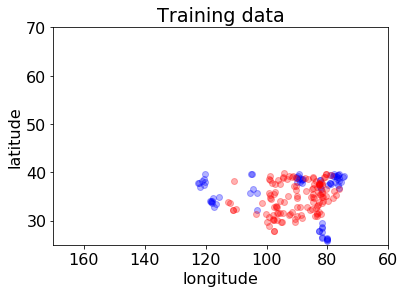

In [20]:
show_cities(df_train)
plt.title("Training data");

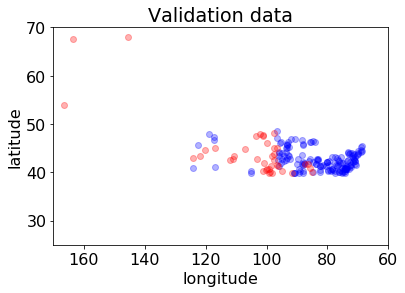

In [21]:
show_cities(df_valid)
plt.title("Validation data");

#### Terminology: test vs. validation

- Some of you may have heard of "test" data.
- There isn't good concensus on the terminology. What is test? What is validation?
- I will try to use "validation" to refer to data where we have access to the target values.
  - But, unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  
- I will use "deployment" to refer to data where we do **not** have access to the target values.
- We will talk about "test" data soon.

Also:

- Deployment error is the thing we _really_ care about.
- We use validation error as a proxy for deployment error, and we hope they are similar.
- So, if our model does well on the validation data, we hope it will do well on deployment data.

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

In [22]:
model = DecisionTreeClassifier(max_depth=None).fit(X_train, y_train)

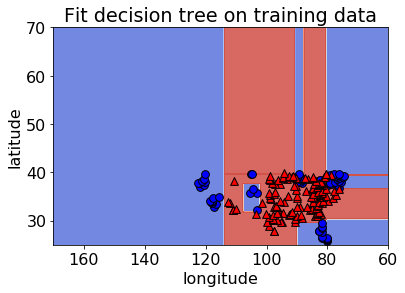

In [23]:
plot_classifier_cities(X_train, y_train, model)
plt.title("Fit decision tree on training data");

In [24]:
print(f"Training error: {1 - model.score(X_train, y_train):.2f}")

Training error: 0.00


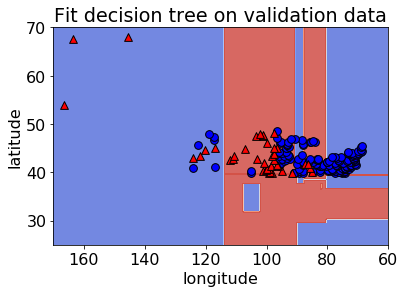

In [25]:
plot_classifier_cities(X_valid, y_valid, model)
plt.title("Fit decision tree on validation data");

In [26]:
print(f"Validation error: {1 - model.score(X_valid, y_valid):.2f}")

Validation error: 0.30


- What is going on here???
- We have terrible accuracy on the test set!
- Maybe we shouldn't have split the dataset halfway in order, because it ended up as south and north.
- Solution: shuffle the rows before splitting.
  - scikit-learn's `train_test_split()` is the most common function used to split your data into train/test sets
  - it shuffles the data first, then splits it.
  - again, other people use the word "test" where I use "validation" ... I wish it was called `train_validation_split()`.

In [27]:
from sklearn.model_selection import train_test_split

In [33]:
df_train_shuffle, df_valid_shuffle = train_test_split(df, test_size=0.5,
                                                     random_state=1)

In [29]:
X_train = df_train_shuffle.drop(columns=['vote'])
y_train = df_train_shuffle[['vote']]

X_test  = df_valid_shuffle.drop(columns=['vote'])
y_test  = df_valid_shuffle[['vote']]

In [ ]:
# alternate syntax
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5)

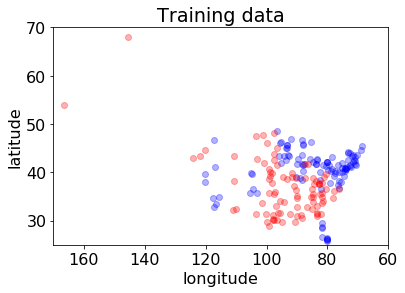

In [30]:
show_cities(df_train_shuffle)
plt.title("Training data");

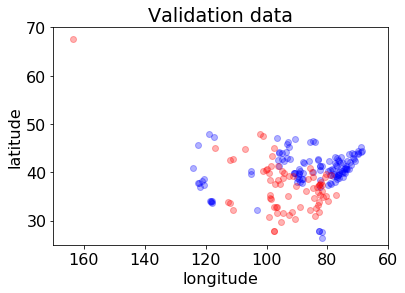

In [31]:
show_cities(df_valid_shuffle)
plt.title("Validation data");

- This split is better for what we call the "iid assumption".
- In short, we hope the train/deploy data look similar (and thus, by extension, your train/validation/test/deploy data). 
- This is a fundamental assumption of supervised learning.
- The more this is violated, the more problems we will have.

In [32]:
model = DecisionTreeClassifier(max_depth=None).fit(X_train, y_train)
print(f"Training error: {1 - model.score(X_train, y_train):.2f}")
print(f"Validation error: {1 - model.score(X_valid, y_valid):.2f}")

Training error: 0.00
Validation error: 0.08


- The validation error is much better now but...
- But it seems that the error rate on our training data may NOT be a good indicator of error rate on unseen data.
- This is caused by **overfitting**.

## Overfitting and the "fundamental trade-off" (15 mins)
- Let's observe what happens to our train/test error as we change max_depth

In [34]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1)

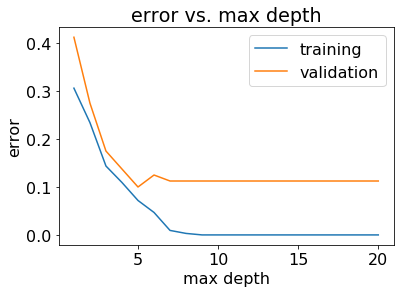

In [35]:
# calculation loop
max_depth = []
train_error = []
valid_error = []
for depth in np.arange(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1).fit(X_train, y_train)  
    max_depth.append(depth)    
    train_error.append(1 - model.score(X_train, y_train))
    valid_error.append(1 - model.score(X_valid, y_valid))

plt.plot(max_depth, train_error, label="training");
plt.plot(max_depth, valid_error, label="validation");
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");
plt.legend();

- We see that validation error does not necessarily decrease with training error.
- As we make a more complex model, we are fitting to the peculiarities in our training data.
- These "peculiarities" do not generalize well to new data.
- There is usually a point at which test error levels off or even gets worse!
- (In this case, nothing is changing after depth 9 or so, but this is specific to decision trees)

### "The fundamental trade-off"

$E_{deploy} = E_{train} + E_{approx}$

$E_{approx} = (E_{deploy} - E_{train})$

- There is generally a "trade-off" between complexity and deployment error
- A more complex model (e.g., higher depth tree) will fit closer to the peculiarities of the training data
- i.e., $E_{approx}$ tends to get bigger as our model becomes more complex
- This means it will likely not generalise well to new data!
- $E_{approx}$ tends to get smaller with more data

- **Underfitting**: decision stump, low $E_{approx}$ but might be high $E_{train}$ (not sensitive to training set)
- **Overfitting**: very deep tree, low $E_{train}$ but might be high $E_{approx}$ (highly sensitive to training set)

Note: this fundamental trade-off also called the [bias/variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) in statistics.

### Finding the "optimal model"

- We could pick the model with the lowest validation error.
- This is a reasonable approach for now.
- But it would also be nice to have a model with low approximation error if possible.


### Validation vs. deployment

- A big problem is that we use validation error as a proxy for deployment error, but it might not be.
- We'll have to revisit this issue as we go through the course.

# Break (5 mins)

## Splitting your data and cross-validation (15 mins)

- There is no hard and fast rule for how you should split your data.
- Some common splits are 90/10, 80/20, 70/30 (training/validation).

### Problems with having a single train/validation split
- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

### A solution: $k$-fold cross-validation

- The figure below shows 5-fold cross-validation:

```
for hyperparameters in (hypers1, hypers2, ...):
    score = cross_val_score(hypers1)
pick hypers with best score
```

Unpack this a bit...

```
for hyperparameters in (hypers1, hypers2, ...):
    for fold in folds:
        get score give fold and hypers
    compute average score
pick hypers with best score
```

<img src='img/cv.png' width="700">

- Helps us use all of our data for training/testing!
- Get a more "robust" measure of error on unseen data.
- Split the data into $k$ folds ($k>2$, often $k=10$).
- Each "fold" gets a turn at being the validation set.
- We then average our $k$ results.

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
model = DecisionTreeClassifier(max_depth=1)

In [38]:
cv_score = cross_val_score(model, X, y, cv=10)
cv_score

array([0.41463415, 0.41463415, 0.41463415, 0.68292683, 0.825     ,
       0.6       , 0.58974359, 0.58974359, 0.58974359, 0.58974359])

In [39]:
print(f"Average cross-validation score = {np.mean(cv_score):.2f}")

Average cross-validation score = 0.57


## True/False questions (25 min)

#### Overfitting and the fundamental tradeoff

1. In supervised learning, the training error is always lower than the validation error.
1. The fundamental tradeoff of ML states that as training error goes down, validation error goes up.
2. More "complicated" models are more likely to overfit than "simple" ones.
3. If we had an infinite amount of training data, overfitting would not be a problem.
4. If our training error is extremely low, that means we're overfitting.

<br><br><br><br><br><br><br><br>

#### Cross-validation -> Piazza

1. $k$-fold cross validation calls `fit` $k$ times and `predict` $k$ times.
2. The goal of cross-validation is to obtain a better estimate of test error than just using a single validation set.
3. The main disadvantage of using a large $k$ in cross-validation is running time.
4. $2$-fold cross validation is the same thing as using a validation set that's 50% the size of your training set.